# DATASET

In [ ]:
import numpy as np

train_data = np.loadtxt("ECG200_TRAIN.txt", delimiter=None)


In [ ]:
cnt = sum(1 for i in train_data if i[0] == 1)
cnt2 = len(train_data) - cnt

print(cnt, cnt2)


69 31


In [ ]:
X_train, y_train = train_data[:, 1:], train_data[:,0 ]

test_data = np.loadtxt("ECG200_TEST.txt", delimiter=None)
X_test, y_test = test_data[:, 1:], test_data[:, 0]

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


# Reshape X_train and X_test to 3D (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Reshaped X_train:", X_train.shape)
print("Reshaped X_test:", X_test.shape)

X_test shape: (100, 96)
y_test shape: (100,)
Reshaped X_train: (100, 96, 1)
Reshaped X_test: (100, 96, 1)


# T-REP

In [ ]:
import zipfile
import os
import sys
zip_path = "T-Rep-main.zip"
extract_path = "."

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)


sys.path.append("./T-Rep-main")

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from trep import TRep

trep = TRep(
    input_dims=1,
    device=0,
    time_embedding='t2v_sin',
    output_dims=128
)
loss_log = trep.fit(X_train, n_epochs=80, verbose=1)

# Compute timestamp-level representations for test set
train_repr = trep.encode(X_train)  # n_instances x n_timestamps x output_dims
test_repr = trep.encode(X_test)  # n_instances x n_timestamps x output_dims

print(train_repr.shape, test_repr.shape)




Training data shape: (100, 96, 1)
(100, 96, 128) (100, 96, 128)


In [ ]:
# Flatten train_repr and test_repr into 2D arrays for SVM
train_repr_flat = train_repr.reshape(train_repr.shape[0], -1)
test_repr_flat = test_repr.reshape(test_repr.shape[0], -1)


print("Flattened train_repr shape:", train_repr_flat.shape)  # (n_samples, n_timestamps * output_dims)
print("Flattened test_repr shape:", test_repr_flat.shape)    # (n_samples, n_timestamps * output_dims)

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_repr_flat, y_train)
y_pred = svm_classifier.predict(test_repr_flat)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')


print("SVM Accuracy:", accuracy)
print("SVM F1-score:", f1)

np.save("trep_train_embeddings.npy", train_repr)
np.save("trep_test_embeddings.npy", test_repr)

Flattened train_repr shape: (100, 12288)
Flattened test_repr shape: (100, 12288)
SVM Accuracy: 0.85
SVM F1-score: 0.8837209302325582


# TS-2-VEC

In [ ]:
import zipfile
import os
import sys
zip_path = "ts2vec-main.zip"
extract_path = "."

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)


sys.path.append("./ts2vec-main")

In [ ]:
from ts2vec import TS2Vec


config = dict(
        batch_size=8,
        lr=0.001,
        output_dims=128,
        max_train_length=96
    )


model = TS2Vec(
        input_dims=X_train.shape[-1],
        device='cpu',
        **config
    )

loss_log = model.fit(
        X_train,
        n_epochs=50,
        n_iters=10,
        verbose=True
    )


train_repr = model.encode(X_train, encoding_window=None) #encoding window can be 'full series to have one embedding for whole ts instead emeddings for timesteps
test_repr = model.encode(X_test, encoding_window=None)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score



train_repr_flat = train_repr.reshape(train_repr.shape[0], -1)
test_repr_flat = test_repr.reshape(test_repr.shape[0], -1)


print("Flattened train_repr shape:", train_repr_flat.shape)  # (n_samples, n_timestamps * output_dims)
print("Flattened test_repr shape:", test_repr_flat.shape)    # (n_samples, n_timestamps * output_dims)

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_repr_flat, y_train)
y_pred = svm_classifier.predict(test_repr_flat)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')


print("SVM Accuracy:", accuracy)
print("SVM F1-score:", f1)


np.save("ts2vec_train_embeddings.npy", train_repr)
np.save("ts2vec_test_embeddings.npy", test_repr)

Flattened train_repr shape: (100, 12288)
Flattened test_repr shape: (100, 12288)
SVM Accuracy: 0.84
SVM F1-score: 0.8709677419354839


#BASELINE (FOR COMPARISON)

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)



scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)

def extract_features(data):
    return np.column_stack([
        np.mean(data, axis=1),       # Mean
        np.std(data, axis=1),        # Standard Deviation
        np.min(data, axis=1),        # Minimum
        np.max(data, axis=1),        # Maximum
        np.median(data, axis=1)      # Median
    ])

# Extract statistical features
X_train_stat = extract_features(X_train_flat)
X_test_stat = extract_features(X_test_flat)

# Normalize
X_train_stat = scaler.fit_transform(X_train_stat)
X_test_stat = scaler.transform(X_test_stat)

# Train SVM
svm = SVC(kernel='linear')
svm.fit(X_train_stat, y_train)
y_pred_stat = svm.predict(X_test_stat)
accuracy_stat = accuracy_score(y_test, y_pred_stat)
print("Baseline Accuracy (Statistical Features):", accuracy_stat)


Baseline Accuracy (Statistical Features): 0.8


# EMBEDDINGS VISUALIZATION AND ANALYSIS

(100, 96, 128)
(100, 96, 128)


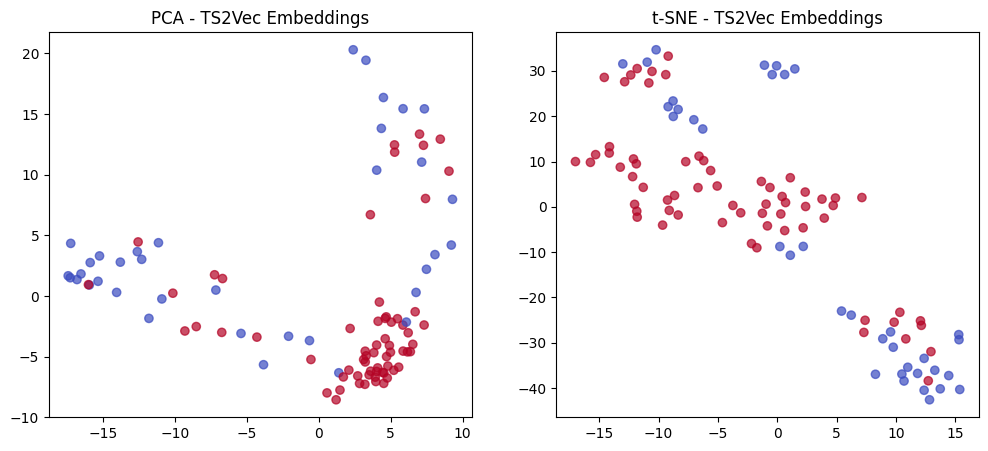

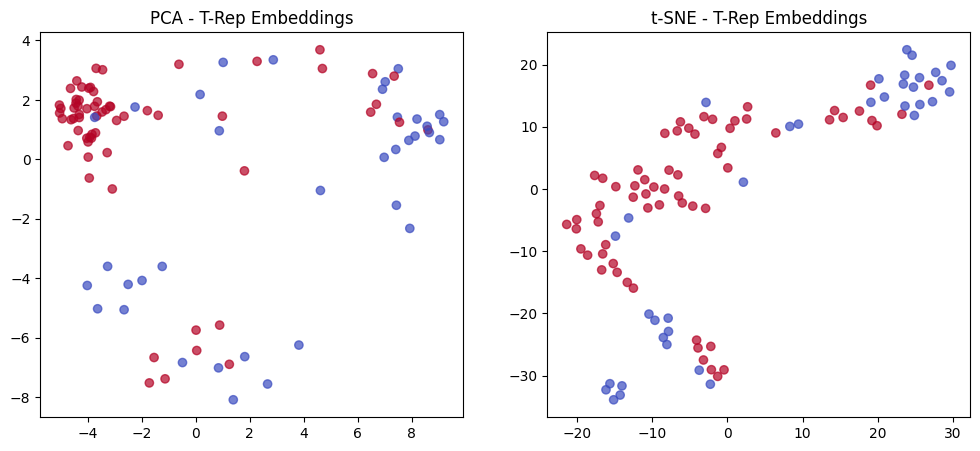

In [ ]:
TS2Vec_embeddings = np.load("ts2vec_test_embeddings.npy")
TRep_embeddings = np.load("trep_test_embeddings.npy")

print(TS2Vec_embeddings.shape)
print(TRep_embeddings.shape)


if TS2Vec_embeddings.ndim == 3:
    TS2Vec_embeddings = TS2Vec_embeddings.reshape(TS2Vec_embeddings.shape[0], -1)
if TRep_embeddings.ndim == 3:
    TRep_embeddings = TRep_embeddings.reshape(TRep_embeddings.shape[0], -1)


# sum/mean over timesteps (axis=1) to get (100, 128)
#TS2Vec_embeddings = TS2Vec_embeddings.mean(axis=1)  # Shape: (100, 128)
#TRep_embeddings = TRep_embeddings.mean(axis=1)      # Shape: (100, 128)


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def reduce_and_plot(embeddings, labels, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)

    tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    tsne_result = tsne.fit_transform(embeddings)


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title(f"PCA - {title}")


    plt.subplot(1, 2, 2)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title(f"t-SNE - {title}")

    plt.show()

reduce_and_plot(TS2Vec_embeddings, y_test, "TS2Vec Embeddings")
reduce_and_plot(TRep_embeddings, y_test, "T-Rep Embeddings")


In [ ]:
from sklearn.neighbors import NearestNeighbors
def find_neighbors(embedding, embeddings, k=5, metric='euclidean'):
    neighbors_model = NearestNeighbors(n_neighbors=k, metric=metric)
    neighbors_model.fit(embeddings)

    distances, neighbors = neighbors_model.kneighbors([embedding])

    return neighbors[0], distances[0]  # Return the indices and distances of the neighbors


def analyze_neighbors(embedding, embeddings, labels, k=5, metric='euclidean'):

    neighbors_indices, distances = find_neighbors(embedding, embeddings, k, metric)

    print(f"Query Time Series (Index {neighbors_indices[0]}):")
    print(f"Class: {labels[neighbors_indices[0]]}")
    print(f"Embedding: {embedding}")

    print(f"\nNearest {k} Neighbors:")
    for idx in neighbors_indices:
        print(f"Index: {idx}, Class: {labels[idx]}, Distance: {distances[neighbors_indices.tolist().index(idx)]}")

    print("\n")


example_indices = [0, 5, 10, 20]

for idx in example_indices:
    print(f"Analyzing TS2Vec Neighbors for Test Sample {idx}:")
    analyze_neighbors(TS2Vec_embeddings[idx], TS2Vec_embeddings, y_test, k=5, metric='cosine')

    print(f"Analyzing T-Rep Neighbors for Test Sample {idx}:")
    analyze_neighbors(TRep_embeddings[idx], TRep_embeddings, y_test, k=5, metric='cosine')
    print("\n" + "="*50 + "\n")



Analyzing TS2Vec Neighbors for Test Sample 0:
Query Time Series (Index 0):
Class: 1.0
Embedding: [-0.24292451  0.22326657  0.21751937 ... -0.3173889  -0.00120082
 -0.13983986]

Nearest 5 Neighbors:
Index: 0, Class: 1.0, Distance: 0.0
Index: 40, Class: 1.0, Distance: 0.012877047061920166
Index: 78, Class: 1.0, Distance: 0.01461184024810791
Index: 21, Class: 1.0, Distance: 0.017580687999725342
Index: 23, Class: 1.0, Distance: 0.01781564950942993


Analyzing T-Rep Neighbors for Test Sample 0:
Query Time Series (Index 0):
Class: 1.0
Embedding: [ 0.11126814  0.24290574 -0.02531692 ... -0.0556583   0.07389763
  0.28405255]

Nearest 5 Neighbors:
Index: 0, Class: 1.0, Distance: 3.5762786865234375e-07
Index: 56, Class: 1.0, Distance: 0.006530642509460449
Index: 40, Class: 1.0, Distance: 0.009098410606384277
Index: 78, Class: 1.0, Distance: 0.010236382484436035
Index: 8, Class: 1.0, Distance: 0.010772228240966797




Analyzing TS2Vec Neighbors for Test Sample 5:
Query Time Series (Index 5):
Clas

#MASKING

In [ ]:
import numpy as np
import os
import zipfile
import sys
from sklearn.svm import SVC


X_train = np.loadtxt("ECG200_TRAIN.txt", delimiter=None)[:, 1:]
y_train = np.loadtxt("ECG200_TRAIN.txt", delimiter=None)[:, 0]
X_test = np.loadtxt("ECG200_TEST.txt", delimiter=None)[:, 1:]
y_test = np.loadtxt("ECG200_TEST.txt", delimiter=None)[:, 0]


def mask_missing_data(X, missing_percentage=0.2):
    masked_X = X.copy()
    n_samples, n_timesteps = masked_X.shape
    n_missing_timesteps = int(n_timesteps * missing_percentage)

    for i in range(n_samples):
        missing_indices = np.random.choice(n_timesteps, n_missing_timesteps, replace=False)
        masked_X[i, missing_indices] = 0

    return masked_X


X_train_masked = mask_missing_data(X_train, missing_percentage=0.2)
X_test_masked = mask_missing_data(X_test, missing_percentage=0.2)

X_train_masked = X_train_masked.reshape(X_train_masked.shape[0], X_train_masked.shape[1], 1)
X_test_masked = X_test_masked.reshape(X_test_masked.shape[0], X_test_masked.shape[1], 1)


zip_path = "T-Rep-main.zip"
extract_path = "."
os.makedirs(extract_path, exist_ok=True)



with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

sys.path.append("./T-Rep-main")


from sklearn.metrics import accuracy_score, f1_score
from trep import TRep


trep = TRep(
    input_dims=1,
    device=0,
    time_embedding='t2v_sin',
    output_dims=128
)

loss_log = trep.fit(X_train_masked, n_epochs=80, verbose=1)
train_repr = trep.encode(X_train_masked)
test_repr = trep.encode(X_test_masked)

train_repr_flat = train_repr.reshape(train_repr.shape[0], -1)
test_repr_flat = test_repr.reshape(test_repr.shape[0], -1)


svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_repr_flat, y_train)


y_pred = svm_classifier.predict(test_repr_flat)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print("SVM Accuracy:", accuracy)
print("SVM F1-score:", f1)

np.save("trep_train_embeddings_masked.npy", train_repr)
np.save("trep_test_embeddings_masked.npy", test_repr)


Training data shape: (100, 96, 1)
SVM Accuracy: 0.83
SVM F1-score: 0.8702290076335878


In [ ]:
import zipfile
import os
import sys
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score


def mask_missing_data(X, missing_percentage=0.2):
    masked_X = X.copy()
    n_samples, n_timesteps = masked_X.shape
    n_missing_timesteps = int(n_timesteps * missing_percentage)

    for i in range(n_samples):
        missing_indices = np.random.choice(n_timesteps, n_missing_timesteps, replace=False)
        masked_X[i, missing_indices] = 0
    return masked_X


X_train = np.loadtxt("ECG200_TRAIN.txt", delimiter=None)[:, 1:]
y_train = np.loadtxt("ECG200_TRAIN.txt", delimiter=None)[:, 0]
X_test = np.loadtxt("ECG200_TEST.txt", delimiter=None)[:, 1:]
y_test = np.loadtxt("ECG200_TEST.txt", delimiter=None)[:, 0]

X_train_masked = mask_missing_data(X_train, missing_percentage=0.2)
X_test_masked = mask_missing_data(X_test, missing_percentage=0.2)


X_train_masked = X_train_masked.reshape(X_train_masked.shape[0], X_train_masked.shape[1], 1)
X_test_masked = X_test_masked.reshape(X_test_masked.shape[0], X_test_masked.shape[1], 1)

zip_path = "ts2vec-main.zip"
extract_path = "."
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

sys.path.append("./ts2vec-main")

from ts2vec import TS2Vec


config = dict(
    batch_size=8,
    lr=0.001,
    output_dims=128,
    max_train_length=96
)


model = TS2Vec(
    input_dims=X_train_masked.shape[-1],
    device='cpu',
    **config
)

loss_log = model.fit(
    X_train_masked,
    n_epochs=50,
    n_iters=10,
    verbose=True
)


train_repr = model.encode(X_train_masked, encoding_window=None)
test_repr = model.encode(X_test_masked, encoding_window=None)
train_repr_flat = train_repr.reshape(train_repr.shape[0], -1)
test_repr_flat = test_repr.reshape(test_repr.shape[0], -1)
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_repr_flat, y_train)
y_pred = svm_classifier.predict(test_repr_flat)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print("SVM Accuracy:", accuracy)
print("SVM F1-score:", f1)


np.save("ts2vec_train_embeddings_masked.npy", train_repr)
np.save("ts2vec_test_embeddings_masked.npy", test_repr)


SVM Accuracy: 0.81
SVM F1-score: 0.8571428571428571


(100, 96, 128)
(100, 96, 128)


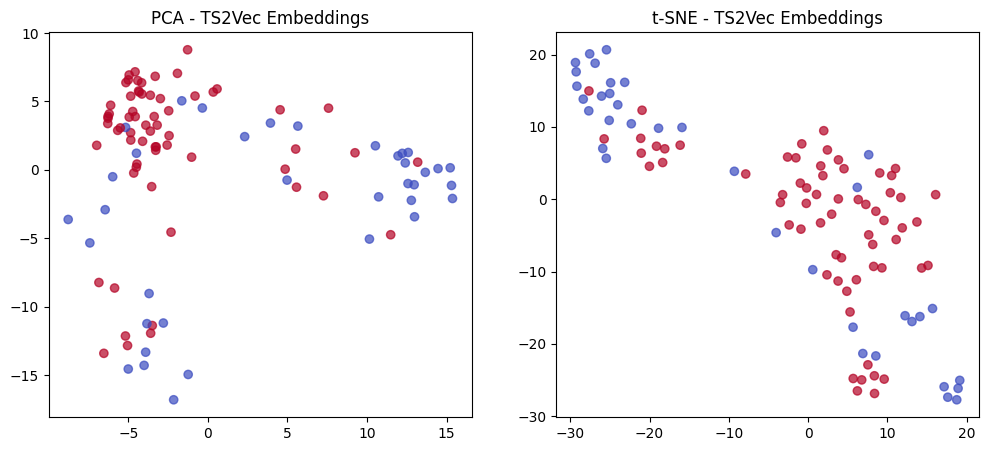

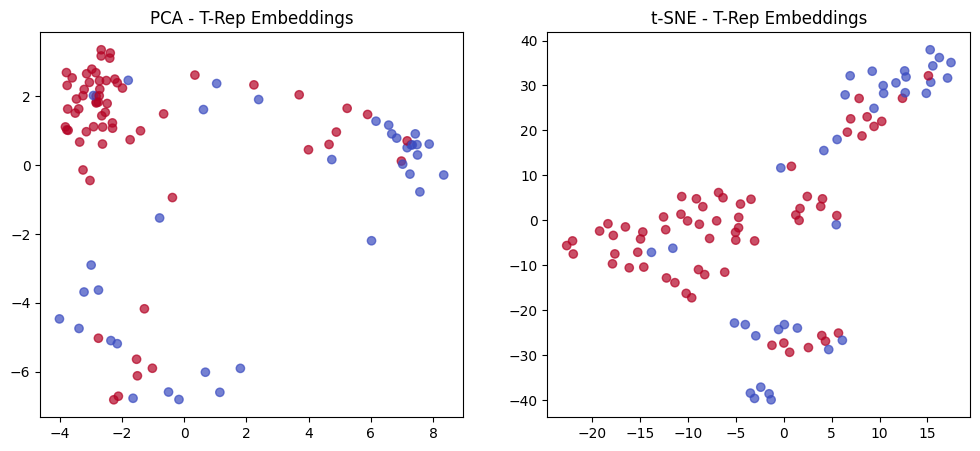

In [ ]:
TS2Vec_embeddings = np.load("ts2vec_test_embeddings_masked.npy")
TRep_embeddings = np.load("trep_test_embeddings_masked.npy")

print(TS2Vec_embeddings.shape)
print(TRep_embeddings.shape)


if TS2Vec_embeddings.ndim == 3:
    TS2Vec_embeddings = TS2Vec_embeddings.reshape(TS2Vec_embeddings.shape[0], -1)
if TRep_embeddings.ndim == 3:
    TRep_embeddings = TRep_embeddings.reshape(TRep_embeddings.shape[0], -1)


# sum/mean over timesteps (axis=1) to get (100, 128)
#TS2Vec_embeddings = TS2Vec_embeddings.mean(axis=1)  # Shape: (100, 128)
#TRep_embeddings = TRep_embeddings.mean(axis=1)      # Shape: (100, 128)


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def reduce_and_plot(embeddings, labels, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)

    tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    tsne_result = tsne.fit_transform(embeddings)


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title(f"PCA - {title}")


    plt.subplot(1, 2, 2)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title(f"t-SNE - {title}")

    plt.show()

reduce_and_plot(TS2Vec_embeddings, y_test, "TS2Vec Embeddings")
reduce_and_plot(TRep_embeddings, y_test, "T-Rep Embeddings")


In [ ]:
from sklearn.neighbors import NearestNeighbors
def find_neighbors(embedding, embeddings, k=5, metric='euclidean'):
    neighbors_model = NearestNeighbors(n_neighbors=k, metric=metric)
    neighbors_model.fit(embeddings)

    distances, neighbors = neighbors_model.kneighbors([embedding])

    return neighbors[0], distances[0]  # Return the indices and distances of the neighbors


def analyze_neighbors(embedding, embeddings, labels, k=5, metric='euclidean'):

    neighbors_indices, distances = find_neighbors(embedding, embeddings, k, metric)

    print(f"Query Time Series (Index {neighbors_indices[0]}):")
    print(f"Class: {labels[neighbors_indices[0]]}")
    print(f"Embedding: {embedding}")

    print(f"\nNearest {k} Neighbors:")
    for idx in neighbors_indices:
        print(f"Index: {idx}, Class: {labels[idx]}, Distance: {distances[neighbors_indices.tolist().index(idx)]}")

    print("\n")


example_indices = [0, 5, 10, 20]

for idx in example_indices:
    print(f"Analyzing TS2Vec Neighbors for Test Sample {idx}:")
    analyze_neighbors(TS2Vec_embeddings[idx], TS2Vec_embeddings, y_test, k=5, metric='cosine')

    print(f"Analyzing T-Rep Neighbors for Test Sample {idx}:")
    analyze_neighbors(TRep_embeddings[idx], TRep_embeddings, y_test, k=5, metric='cosine')
    print("\n" + "="*50 + "\n")



Analyzing TS2Vec Neighbors for Test Sample 0:
Query Time Series (Index 0):
Class: 1.0
Embedding: [-0.09427036  0.05461129  0.09331523 ...  0.07748026  0.0222452
 -0.25818598]

Nearest 5 Neighbors:
Index: 0, Class: 1.0, Distance: 1.1920928955078125e-07
Index: 78, Class: 1.0, Distance: 0.10509192943572998
Index: 23, Class: 1.0, Distance: 0.13932323455810547
Index: 89, Class: 1.0, Distance: 0.14494848251342773
Index: 56, Class: 1.0, Distance: 0.14637166261672974


Analyzing T-Rep Neighbors for Test Sample 0:
Query Time Series (Index 0):
Class: 1.0
Embedding: [ 0.10126086  0.10851011 -0.10193329 ... -0.02642983  0.17470554
  0.15605964]

Nearest 5 Neighbors:
Index: 0, Class: 1.0, Distance: 5.960464477539062e-07
Index: 56, Class: 1.0, Distance: 0.01678311824798584
Index: 95, Class: 1.0, Distance: 0.017621099948883057
Index: 23, Class: 1.0, Distance: 0.018407344818115234
Index: 55, Class: -1.0, Distance: 0.02266383171081543




Analyzing TS2Vec Neighbors for Test Sample 5:
Query Time Series 